In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import xarray as xr
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
import os.path
import h5py as h5
from scipy.spatial import KDTree
import pyproj
from scipy.interpolate import griddata


In [20]:
class Buoys:
    
    global rad, r_earth
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date):
        print(lon_start)
        self.oldlon = lon_start * rad
        self.oldlat = lat_start * rad
        self.lon = lon_start * rad
        self.lat = lat_start * rad
        self.initlon = lon_start * rad
        self.initlat = lat_start * rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        #self.delta_x = np.zeros(lon_start.shape)
        #self.delta_y = np.zeros(lon_start.shape)
        #self.u_ice = np.zeros(lon_start.shape)
        #self.v_ice = np.zeros(lon_start.shape)
        
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
        
    def trajectory(self, new_u, new_v, delta_t):
        #print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg = self.lon/rad % 360
        lat_deg = np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        #idx=getindices_beforestart(self.getdate(), self.startdates)
        #lon_deg[idx] = np.nan
        #lat_deg[idx] = np.nan
        #self.lon[idx] = self.initlon[idx]
        #self.lat[idx] = self.initlat[idx]
        #self.old_u[idx]=0.
        #self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg



# a useful function we'll need
def length_of_latitude_circle(lat=85.):
    r_earth=6.3675*10**6 # radius of Earth in [m]
    rad=np.pi/180.0 # radiant <-> degree  
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km


# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(startdates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices


# load OSISAF data for Northern Hemisphere at a certain date
def loaddate_ofOSISAF(datestring, hemisphere='nh'):
    
    # convert datestring to datetime object
    thedate = datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S")
    
    # let's construct the file name, 
    # e.g. drift-velocities/archive/ice/drift_lr/merged/2019/09/
    # ice_drift_nh_polstere-625_multi-oi_201909011200-201909031200.nc
    pathtofile = "/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/"
    # middle part
    middlefilename="ice_drift_"+hemisphere+"_polstere-625_multi-oi_"
    # e.g. 201907291200-201907311200 (48hr span)
    enddate=thedate + timedelta(days=2)
    # YYYY/MM/ (from end date)
    YYYYMM=enddate.strftime("%Y")+"/"+enddate.strftime("%m")+"/"
    endfilename= thedate.strftime("%Y%m%d%H%M") + "-" + enddate.strftime("%Y%m%d%H%M") + '.nc'
    
    # the OSISAF file to be loaded
    filename=pathtofile + YYYYMM + middlefilename + endfilename
    
    # take previous files in case there is a data gap
    sd=thedate
    ed=enddate
    while os.path.isfile(filename)!=True:
        # try previous file
        sd=sd - timedelta(days=1)
        ed=ed - timedelta(days=1)
        # YYYY/MM/ (from end date)
        YYYYMM=ed.strftime("%Y")+"/"+ed.strftime("%m")+"/"
        endfilename= sd.strftime("%Y%m%d%H%M") + "-" + ed.strftime("%Y%m%d%H%M") + '.nc'
        filename=pathtofile + YYYYMM + middlefilename + endfilename
        print('data gap: try previous file '+filename+' ...')
    
    #print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)
    #xc=fl.variables['xc']
    #yc=fl.variables['yc']
    #XC,YC=np.meshgrid(xc,yc)
    
    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])

    # lon lat at the end of the displacement
    lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
    lat_end=np.squeeze(fl.variables['lat1'][0,:,:])
    
    # close the file
    fl.close()
    
    # compute Ufield from end points and start points (48hour change)
    deltalon=lon_end-lon_start
    deltalon[deltalon>100.]=deltalon[deltalon>100.]-360.   # jump at -180..180
    deltalon[deltalon<-100.]=deltalon[deltalon<-100.]+360. # jump at -180..180
    Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. / 3.6 # km/h -> m/s
    
    # compute Vfield as well
    Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. / 3.6 #km/h -> m/s
    
    return Ufield, Vfield, lon_start, lat_start


# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(lon_start,lat_start, Ufield,Vfield, objects):
    
    # (lon,lat) tuples of the underlying grid
    A = np.array([lon_start[:,:].flatten(), lat_start[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    lon_adjust = objects.lon/rad
    lon_adjust[lon_adjust>180.] = lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((lon_adjust, objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx = spatial.KDTree(A).query(tuples)[1]
    
    return Ufield[idx], Vfield[idx]


def WGS84toEASE2N(lon, lat):
    '''Converts WGS84 coordinates to EASE2N.

    Params:
        lon (array): the WGS84 longitude to convert
        lat (array): the WGS84 latitude to convert

    Returns:
        (x, y): the corresponding EASE2N x and y coordinates
    '''

    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


def EASE2NtoWGS84(x, y):

    EASE2 = "+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = pyproj.Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    return lon, lat


def load_MISR(MISR_path):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat
        x, y
    '''

    file = h5.File(MISR_path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])
    lat = np.array(file['GeoLocation']['Latitude'])
    x = np.array(file['GeoLocation']['x'])
    y = np.array(file['GeoLocation']['y'])

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    
    
    file.close()

    return data, lon, lat, x, y


def predict_mpf(SIR, R0, l, tau, hnet):
    '''
    Predicts meltpond fraction given an input SIR, based on the model by Landy et al, 2015.
    '''
    R = R0 * np.exp(-l * SIR) + tau
    return (1 - np.exp(-R * hnet))


def interpolate_to_MISR(x_in, y_in, data, x_out, y_out):
    '''
    Interpolates data of the shape x_in, y_in to the shape of x_out, y_out.
    
    Params:
        data: the data to be interpolated
        x_in, y_in: the shape of the data to be interpolated
        
    Returns:
        x_out, y_out: the shape to which the data will be interpolated'''
    return griddata((x_in.ravel(), y_in.ravel()), data.ravel( ), (x_out.ravel(), y_out.ravel()), 'nearest').reshape(8000,8000) 


def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"

In [21]:
year = 2017
print(f'------ Processing {year} ------')

YEAR = year
START_DATE = f'{YEAR}-04-01 12:00:00'
SPACING = 8
DAYS_TO_FORWARD = 183
delta_t = 86400  # in seconds

# retrieve MPF coordinates
coord_fn = '/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5'
coords = h5.File(coord_fn, 'r')
mpf_lon =  np.array(coords['Longitudes'])
mpf_lat = np.array(coords['Latitudes'])
x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)

# retrieve MISR data and coordinates
fn = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
sigma, sigma_lon, sigma_lat, sigma_x, sigma_y = load_MISR(fn)

# take an even subset of the data to reduce computational requirements
all_lats = sigma_lat[::SPACING, ::SPACING].ravel()
all_lons = sigma_lon[::SPACING, ::SPACING].ravel()
all_sigma = sigma[::SPACING, ::SPACING].ravel()

num_points = len(all_lons)
earliest_date = START_DATE
advect_start_date = START_DATE
dates = [advect_start_date]

# create dataframes in which lat, lon and mpf data will be stored
lons = np.zeros((1, num_points))*np.nan
lats = np.zeros((1, num_points))*np.nan
mpfs = np.zeros((1, num_points))*np.nan
sir = np.zeros((1, num_points))*np.nan
x = np.zeros((1, num_points))*np.nan
y = np.zeros((1, num_points))*np.nan
lats_df = pd.DataFrame(data=lats, index=dates)
lons_df = pd.DataFrame(data=lons, index=dates)
mpfs_df = pd.DataFrame(data=mpfs, index=dates)
sir_df = pd.DataFrame(data=sir, index=dates)
x_df = pd.DataFrame(data=x, index=dates)
y_df = pd.DataFrame(data=y, index=dates)

lats_df.loc[advect_start_date] = all_lats # np.arange(90.,110.,1.)
lons_df.loc[advect_start_date] = all_lons # np.arange(90.,110.,1.)
sir_df.loc[advect_start_date] = all_sigma

all_x, all_y = WGS84toEASE2N(all_lons, all_lats)
x_df.loc[advect_start_date] = all_x
y_df.loc[advect_start_date] = all_y

# format the starting date, then load MPF data for that day
date = datetime.strptime(advect_start_date, "%Y-%m-%d %H:%M:%S")
start_YYYYMMDD = date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")
try:
    if YEAR >= 2017 and YEAR <= 2023:
        fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{start_YYYYMMDD}.nc'
    elif YEAR >= 2002 and YEAR <= 2011:
        fn = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}/data/mpd1_{start_YYYYMMDD}.nc'
    ds = xr.open_dataset(fn)
    mpf = ds['mpf']
except Exception as e:
    mpf = np.zeros(num_points)
    mpf[:] = np.nan
    print(f'Data could not be retrieved for advection start date, {date}: {e}')

# find all MPFs within each sigma grid cell
tree_mpf = KDTree(list(zip(x_mpf.ravel(), y_mpf.ravel())))
tree_sir = KDTree(list(zip(all_x.ravel(), all_y.ravel())))
x_sigma, y_sigma = WGS84toEASE2N(all_lons, all_lats)
max_radius = 10000
indices_within_grid = tree_mpf.query_ball_point(list(zip(x_sigma, y_sigma)), r = max_radius)

# calculate the mean MPF within the radius for each sigma grid cell, and add to df
if len(indices_within_grid) > 0:
    mean_mpf = np.zeros(num_points)
    for i in range(num_points):
        mean_mpf[i] = np.mean(np.asarray(mpf).ravel()[indices_within_grid[i]])
mean_mpf[mean_mpf==0] = np.nan
mpfs_df.loc[advect_start_date] = np.asarray(mean_mpf).ravel()

# initialise 'Bouys' for all points to be advected
points = Buoys(lons_df.loc[advect_start_date], lats_df.loc[advect_start_date], advect_start_date, earliest_date)

# advect all points by the set number of days
forwarded_mpfs = []
for i in np.arange(1, DAYS_TO_FORWARD+1):
    print(f'This is year {YEAR}, day #{i} of {DAYS_TO_FORWARD}')

    Ufield, Vfield, lon_start, lat_start = loaddate_ofOSISAF(points.getdate(), hemisphere='nh')
    U,V = find_UV_atbuoy_pos(lon_start, lat_start, Ufield.flatten(),Vfield.flatten(), points)

    # don't advect buoys when there is no ice
    fixed=np.logical_or(U.mask, V.mask)
    U[fixed]=0.
    V[fixed]=0.

    LON,LAT = points.trajectory(U, V, delta_t=delta_t) # U,V in m/s, delta_t in seconds

    # create dataframe with new lats and lons
    new_lons = pd.DataFrame(LON.rename(points.getdate())).T
    new_lats = pd.DataFrame(LAT.rename(points.getdate())).T
    new_x, new_y = WGS84toEASE2N(LON, LAT)
    date = [points.getdate()]
    new_x_df = pd.DataFrame(new_x, columns=date).T
    new_y_df = pd.DataFrame(new_y, columns=date).T  

    # find new sir
    _, indices_within_grid_sir = tree_sir.query(list(zip(new_x.ravel(), new_y.ravel())), k=1)
    new_sir = np.zeros(num_points)
    for i in range(num_points):
        new_sir[i] = all_sigma[indices_within_grid_sir[i]]
    # convert 0s to nans and append to list
    new_sir[new_sir==0] = np.nan
    new_sir_df = pd.DataFrame(new_sir, columns=date).T  

    # add dataframe with new lats and lons to original one
    lons_df = pd.concat([lons_df, new_lons])
    lats_df = pd.concat([lats_df, new_lats])
    x_df = pd.concat([x_df, new_x_df])
    y_df = pd.concat([y_df, new_y_df])
    sir_df = pd.concat([sir_df, new_sir_df])
    
    x_sigma, y_sigma = WGS84toEASE2N(new_lons, new_lats)

    # get and format current datestring
    date = datetime.strptime(points.getdate(), "%Y-%m-%d %H:%M:%S")
    YYYYMMDD = date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")

    # retrieve MPF data for this day
    try:
        if YEAR >= 2017 and YEAR <= 2023:
            fn = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}/data/mpd1_{YYYYMMDD}.nc'
        elif YEAR >= 2002 and YEAR <= 2011:
            fn = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}/data/mpd1_{YYYYMMDD}.nc'
        ds = xr.open_dataset(fn)
        mpf = ds['mpf']
        print(f'Data retrieved for {date}')
    except Exception as e:
        mpf = np.zeros(896*608)
        mpf[:] = np.nan
        print(f'Data could not be retrieved for {date}: {e}')

    # Query the tree_mpf to find all points within final_lons and final_lats grids
    max_radius = 10000
    indices_within_grid = tree_mpf.query_ball_point(list(zip(x_sigma.ravel(), y_sigma.ravel())), r = max_radius)

    # calculate the mean MPF within the radius for each sigma grid point
    if len(indices_within_grid) > 0:
        mean_mpf = np.zeros(num_points)
        for i in range(num_points):
            mean_mpf[i] = np.mean(np.asarray(mpf).ravel()[indices_within_grid[i]])

    # convert 0s to nans and append to list
    mean_mpf[mean_mpf==0] = np.nan
    forwarded_mpfs.append(mean_mpf)

    ind = format_date(date.strftime("%Y"), date.strftime("%m"), date.strftime("%d"))
    new_mpfs = pd.DataFrame(data=np.asarray(mean_mpf).reshape(1, len(np.asarray(mean_mpf).ravel())), index=[ind])
    mpfs_df = pd.concat([mpfs_df, new_mpfs])

# save dataframe
#mpfs_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{start_YYYYMMDD}_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
#lons_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lon_from_{start_YYYYMMDD}_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
#lats_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lat_from_{start_YYYYMMDD}_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
print(f'Dataframes saved.')


------ Processing 2017 ------


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for advection start date, 2017-04-01 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170401.nc'


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0         -45.000000
1         -44.942638
2         -44.885166
3         -44.827576
4         -44.769867
             ...    
999995    135.230530
999996    135.172729
999997    135.115036
999998    135.057465
999999    135.000000
Name: 2017-04-01 12:00:00, Length: 1000000, dtype: float64
This is year 2017, day #1 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-02 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170402.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #2 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-03 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170403.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #3 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-04 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170404.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #4 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-05 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170405.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #5 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-06 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170406.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #6 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-07 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170407.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #7 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-08 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170408.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #8 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-09 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170409.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #9 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-10 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170410.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #10 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-11 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170411.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #11 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-12 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170412.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #12 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-13 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170413.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #13 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-14 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170414.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #14 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-15 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170415.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #15 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-16 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170416.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #16 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-17 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170417.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #17 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-18 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170418.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #18 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-19 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170419.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #19 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-20 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170420.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #20 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-21 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170421.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #21 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-22 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170422.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #22 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-23 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170423.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #23 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-24 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170424.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #24 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-25 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170425.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #25 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-26 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170426.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #26 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-27 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170427.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #27 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-28 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170428.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #28 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-29 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170429.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #29 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-04-30 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170430.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #30 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-01 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #31 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-02 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #32 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-03 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #33 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-04 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #34 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-05 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #35 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-06 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #36 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-07 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #37 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-08 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #38 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-09 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #39 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-10 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #40 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-11 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #41 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-12 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #42 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-13 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #43 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-14 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #44 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-15 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #45 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-16 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #46 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-17 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #47 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-18 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #48 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-19 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #49 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-20 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #50 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-21 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #51 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-22 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #52 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-23 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #53 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-24 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #54 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-25 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #55 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-26 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #56 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-27 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #57 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-28 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #58 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-29 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #59 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-30 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #60 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-05-31 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #61 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-01 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #62 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-02 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #63 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-03 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #64 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-04 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #65 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-05 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #66 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-06 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #67 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-07 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #68 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-08 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #69 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-09 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #70 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-10 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #71 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-11 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #72 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-12 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #73 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-13 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #74 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-14 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #75 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-15 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #76 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-16 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #77 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-17 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #78 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-18 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #79 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-19 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #80 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-20 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #81 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-21 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #82 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-22 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #83 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-23 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #84 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-24 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #85 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-25 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #86 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-26 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #87 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-27 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #88 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-28 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #89 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-29 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #90 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-06-30 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #91 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-01 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #92 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-02 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #93 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-03 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #94 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-04 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #95 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-05 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #96 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-06 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #97 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-07 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #98 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-08 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #99 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-09 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #100 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-10 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #101 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-11 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #102 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-12 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #103 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-13 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #104 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-14 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #105 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-15 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #106 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-16 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #107 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-17 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #108 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-18 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #109 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-19 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #110 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-20 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #111 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-21 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #112 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-22 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #113 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-23 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #114 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-24 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #115 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-25 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #116 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-26 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #117 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-27 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #118 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-28 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #119 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-29 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #120 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-30 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #121 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-07-31 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #122 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-08-01 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170801.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #123 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-08-02 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170802.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #124 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-08-03 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20170803.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #125 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-04 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #126 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-05 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #127 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-06 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #128 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-07 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #129 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-08 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #130 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-09 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #131 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-10 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #132 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-11 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #133 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-12 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #134 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-13 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #135 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-14 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #136 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-15 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #137 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-16 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #138 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-17 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #139 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-18 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #140 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-19 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #141 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-20 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #142 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-21 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #143 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-22 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #144 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-23 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #145 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-24 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #146 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-25 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #147 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-26 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #148 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-27 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #149 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-28 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #150 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-29 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #151 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-30 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #152 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-08-31 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #153 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-01 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #154 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-02 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #155 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-03 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #156 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-04 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #157 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-05 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #158 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-06 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #159 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-07 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #160 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-08 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #161 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-09 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #162 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-10 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #163 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-11 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #164 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-12 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #165 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-13 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #166 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-14 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #167 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-15 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #168 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-16 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #169 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-17 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #170 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-18 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #171 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-19 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #172 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-20 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #173 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-21 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #174 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-22 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #175 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-23 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #176 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-24 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #177 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-25 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #178 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-26 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #179 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-27 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #180 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-28 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #181 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-29 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #182 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data retrieved for 2017-09-30 12:00:00


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


This is year 2017, day #183 of 183


/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_307571/871356593.py:183: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


Data could not be retrieved for 2017-10-01 12:00:00: [Errno 2] No such file or directory: b'/home/htweedie/melt_ponds/data/OLCI/olci/2017/data/mpd1_20171001.nc'


/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/cpom/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Dataframes saved.


In [22]:
mpfs_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mpf_from_{start_YYYYMMDD}_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
lons_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/lon_from_{start_YYYYMMDD}_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
lats_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/lat_from_{start_YYYYMMDD}_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
sir_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/sir_from_{start_YYYYMMDD}_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')

In [23]:
mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mpf_from_{YEAR}0401_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
lat_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/lat_from_{YEAR}0401_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
lon_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/lon_from_{YEAR}0401_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
sir_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/sir_from_{YEAR}0401_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')

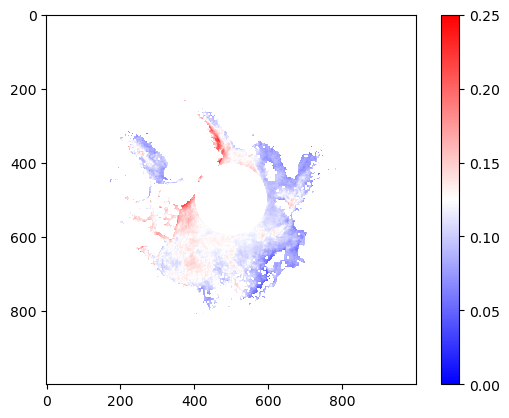

In [24]:
plt.set_cmap('bwr')
plt.imshow(np.asarray(sir_advected.iloc[0]).reshape(1000,1000), vmin=0, vmax=0.25)
plt.colorbar()

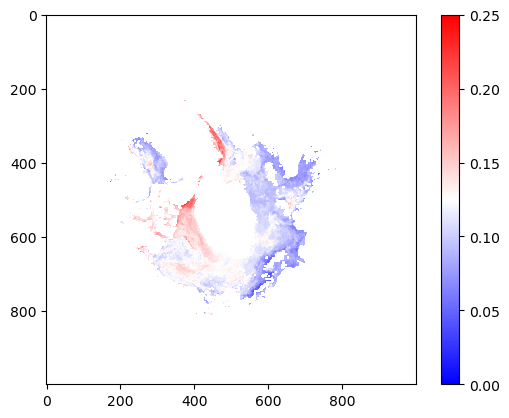

In [28]:
plt.set_cmap('bwr')
plt.imshow(np.asarray(sir_advected.iloc[180]).reshape(1000,1000), vmin=0, vmax=0.25)
plt.colorbar()

In [26]:
np.nanmax(sir_advected.iloc[60])

0.39185869693756104